In [1]:
import os
from pprint import pprint
from csv import reader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score,v_measure_score
from sklearn import linear_model,preprocessing


from scipy.optimize import minimize, Bounds
from scipy.linalg import orth, eigh
from scipy.stats import mode

import statsmodels.api
import statsmodels as sm

import anndata
import scanpy

from glmpca import glmpca

import csv

from tqdm import trange

In [2]:
# Load Belayer functions

import sys

sys.path.append('src')
from utils_IO import *

from harmonic import *
from region_cost_fun import *
from dprelated import *
from dp_post_processing import *
from general_helper_funcs import * # Cong added the helper function script from belayer-develop to belayer repo
from precompute_likelihood import *
from dp_linear_boundary import *
import svg

In [3]:
from importlib import reload

reload(svg)

<module 'svg' from 'src/svg.py'>

# Dataset 1: DLPFC (10x Visium)

## Belayer mode 1: Assume layer boundaries are lines

**Step 0: load data**

In [4]:
# OPTION 1: load from 10x folder
# input_10x_folder='INSERT/PATH/TO/FOLDER/{}'.format(sample)
# count, coords, barcodes, gene_labels=read_input_10xdirectory(input_10x_folder)
# G,N= count.shape

# OPTION 2: load your own file

sample='151508'
H5AD_FILE_LOCATION="/n/fs/ragr-data/users/congma/Codes/spatial_embedding/data/{}/sample_{}.h5ad".format(sample,sample)
adata = anndata.read_h5ad(H5AD_FILE_LOCATION)

gene_labels=np.array(adata.var.index)
count=adata.layers['count'].T
G,N=count.shape
coords=adata.obsm["X_pos"]



**Step 0.5: compute GLM-PCA**

In [5]:
# OPTION 1: generate GLM-PCA and save to file

# glmpca_res = glmpca.glmpca(count, 2*7, fam="poi", penalty=10, verbose=True)
# F_glmpca = glmpca_res['factors']
# np.save('INSERT/PATH/', F_glmpca)

# OPTION 2: load pre-computed GLM-PCs

# replace with your own file
PRESAVED_GLMPCA_FILE='/n/fs/ragr-research/projects/network-mutations/spatial_trans/F_glmpca_2d/F_glmpca_2d_151508_penalty_10_trial_0.npy'
F_glmpca=np.load(PRESAVED_GLMPCA_FILE+''.format(sample))


**Step 1: pre-compute losses for all combinations of linear boundaries**

Note: this takes a long time, so we suggest running on cluster. 
(But once you run this once you do not have to run again)

In [6]:
FOLDER_TO_SAVE_LOSSES_IN="" # add the folder to save precomputation results in

# maximum number of layers
max_nlayers=10

# initialize the object that contains all information for precomputing likelihoods
p = precompute_class(F_glmpca, coords, max_nlayers, FOLDER_TO_SAVE_LOSSES_IN) 

# OPTION 1: no parallelization

p.precompute_likelihood(F_glmpca, coords, max_nlayers, FOLDER_TO_SAVE_LOSSES_IN)


# OPTION 2: parallel using python
# Split the set of all line-bounded regions into num_batches for precomputing likelihoods. The per-region likelihoods of each batch will be stored in a separate file and need to be merged.
# import multiprocessing

# n_processes = 10 # number processes to use in multi-processing.
# num_batches = 1000 # number of batches to split the likelihood precomputation
# p.num_batches = num_batches
# pool = multiprocessing.Pool(processes = n_processes)
# outputs = pool.map(p.precompute_likelihood, np.arange(num_batches))
# p.combine_precomputed_likelihoods()


# OPTION 3: parallel by submitting multiple jobs in slurm



100%|██████████| 204/204 [00:37<00:00,  5.51it/s]
2022-06-27 11:50:38 - INFO - There are 140117502 tuples of boundary end points.
100%|██████████| 204/204 [00:00<00:00, 29357.97it/s]
2022-06-27 11:50:38 - INFO - There are 41412 triples of boundary end points for half circle regions.


**Step 2: run DP using pre-computed losses**

In [7]:
# folder to save the optimal layer boundaries and likelihood values
PREFIX_TO_SAVE_DP = "" 

arr_loss_np, arr_layers_np = run_dp_linear_boundary(FOLDER_TO_SAVE_LOSSES_IN, 
                                                    p.sorted_boundary, 
                                                    max_nlayers, 
                                                    PREFIX_TO_SAVE_DP)


**Step 2.5: Model selection and visualize clusters**

In [8]:
# LOAD pre-computed losses if not already there

FOLDER_TO_SAVE_LOSSES_IN=""
PREFIX_TO_SAVE_DP=""
max_nlayers=10

arr_loss_np=np.load(FOLDER_TO_SAVE_LOSSES_IN + PREFIX_TO_SAVE_DP + "_dp_loss.npy", 
                    allow_pickle=True)
arr_layers_np=np.load(FOLDER_TO_SAVE_LOSSES_IN + PREFIX_TO_SAVE_DP + "_dp_layers.npy", 
                      allow_pickle=True)

p = precompute_class(F_glmpca, coords, max_nlayers, FOLDER_TO_SAVE_LOSSES_IN) 

100%|██████████| 204/204 [00:36<00:00,  5.53it/s]
2022-06-27 11:52:02 - INFO - There are 140117502 tuples of boundary end points.
100%|██████████| 204/204 [00:00<00:00, 29398.32it/s]
2022-06-27 11:52:02 - INFO - There are 41412 triples of boundary end points for half circle regions.


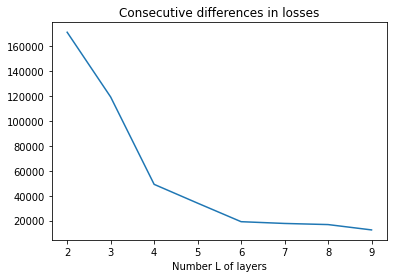

In [9]:
# model selection for number L of layers
# we use L=6

plot_model_selection_nlayers(arr_loss_np[2:])

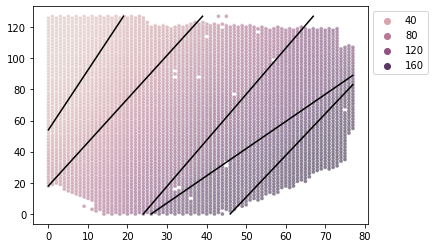

In [10]:
dp_boundaries = arr_layers_np[5] # 5 layer boundaries, or 6 total layers
depth, dp_labels = get_depth_from_linear_boundaries(p.llf.interpolation, dp_boundaries, p.in_tissue)

plt.scatter(coords[:,0], coords[:,1], c="grey", s=5, alpha=0.2)
sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=depth, s=15, alpha=0.5)
for endpoints in dp_boundaries:
    b1, b2 = endpoints
    plt.plot([b1[0], b2[0]], [b1[1], b2[1]], c="black")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

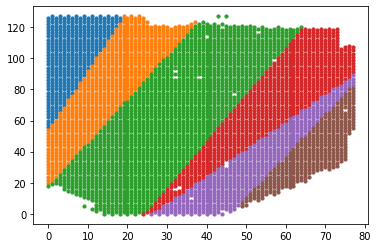

In [11]:
# visualize the clusters

plot_cluster_output(dp_labels, coords)

**Step 3: Spatially varying gene analysis**

In [14]:
# restrict genes
idx_kept=svg.select_commonly_expressed_genes(count, q=0.85, threshold=0, pooling=False)
print("number of kept genes = {}".format(len(idx_kept)))

number of kept genes = 2031


In [194]:
# get slopes, offsets
# (we halve the depth so that it is between 0 and 100)
slope_offsets=svg.segmented_poisson_regression(count[idx_kept,:], 
                                               np.sum(count,axis=0), 
                                               dp_labels, 
                                               0.5*depth)

In [196]:
# For example, the two genes with largest absolute slopes in layer 3: NEFM and HPCAL1
gene_labels[ idx_kept[ np.argsort( np.abs(slope_offsets['slope 2.0']) )[::-1][:2] ] ]

array(['ENSG00000100285', 'ENSG00000115756'], dtype=object)

/tmp/ipykernel_8116/985552891.py:55: RuntimeWarning: divide by zero encountered in log
  np.log( (binned_count[gene_index,pts_seg]) / binned_exposure[pts_seg] ))
/tmp/ipykernel_8116/985552891.py:55: RuntimeWarning: divide by zero encountered in log
  np.log( (binned_count[gene_index,pts_seg]) / binned_exposure[pts_seg] ))
/tmp/ipykernel_8116/985552891.py:55: RuntimeWarning: divide by zero encountered in log
  np.log( (binned_count[gene_index,pts_seg]) / binned_exposure[pts_seg] ))
/tmp/ipykernel_8116/985552891.py:55: RuntimeWarning: divide by zero encountered in log
  np.log( (binned_count[gene_index,pts_seg]) / binned_exposure[pts_seg] ))


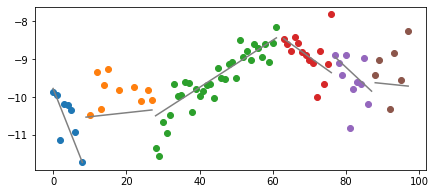

In [259]:
# we can also visualize the piecewise linear expression functions

# first, bin the data
binning_output=svg.bin_data(count, dp_labels, 0.5*depth)

# plot NEFH
# (note that bins with count 0 are not plotted which is why fits are slightly off)
g=np.where(gene_labels=='ENSG00000100285')[0][0]
svg.plot_gene_pwlinear(g, idx_kept, count, slope_offsets, 0.5*depth, binning_output)

/tmp/ipykernel_8116/985552891.py:55: RuntimeWarning: divide by zero encountered in log
  np.log( (binned_count[gene_index,pts_seg]) / binned_exposure[pts_seg] ))
/tmp/ipykernel_8116/985552891.py:55: RuntimeWarning: divide by zero encountered in log
  np.log( (binned_count[gene_index,pts_seg]) / binned_exposure[pts_seg] ))


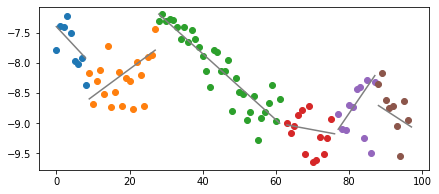

In [260]:
# plot HPCAL1
g=np.where(gene_labels=='ENSG00000115756')[0][0]
plot_gene_pwlinear(g, idx_kept, count, slope_offsets, 0.5*depth, binning_output)

## Belayer mode 2: Assume layer boundaries are _parallel_ lines

Faster, but this is a strict assumption

**Step 0: load data**

In [3]:
# OPTION 1: load from 10x folder
# input_10x_folder='INSERT/PATH/TO/FOLDER/{}'.format(sample)
# count, coords, barcodes, gene_labels=read_input_10xdirectory(input_10x_folder)
# G,N= count.shape

# OPTION 2: load your own file

sample='151508'
H5AD_FILE_LOCATION="/n/fs/ragr-data/users/congma/Codes/spatial_embedding/data/{}/sample_{}.h5ad".format(sample,sample)
adata = anndata.read_h5ad(H5AD_FILE_LOCATION)

gene_labels=np.array(adata.var.index)
count=adata.layers['count'].T
G,N=count.shape
coords=adata.obsm["X_pos"]

**Step 0.5: run GLM-PCA**

In [4]:
# OPTION 1: generate GLM-PCA and save to file

# glmpca_res = glmpca.glmpca(count, 2*7, fam="poi", penalty=10, verbose=True)
# F_glmpca = glmpca_res['factors']
# np.save('INSERT/PATH/', F_glmpca)

# OPTION 2: load pre-computed GLM-PCs

# replace with your own file
PRESAVED_GLMPCA_FILE='/n/fs/ragr-research/projects/network-mutations/spatial_trans/F_glmpca_2d/F_glmpca_2d_151508_penalty_10_trial_0.npy'
F_glmpca=np.load(PRESAVED_GLMPCA_FILE+''.format(sample))


**Step 1: run Belayer DP on different rotations of tissue slice**

In [5]:
# Run Belayer DP

max_nlayers=8 # max number of layers

# NOTE: results are influenced by different rotation angles
# below we rotate tissue by 0 degrees, ..., 20 degrees
rotation_angle_list=[0,5,10,15,17.5,20]

loss_array,label_dict=rotation_dp(F_glmpca.T, coords, Lmax=max_nlayers, use_buckets=True, 
                          num_buckets=150,rotation_angle_list=rotation_angle_list)



 angle: 0
running DP
finding segments for 1 layers
finding segments for 2 layers
finding segments for 3 layers
finding segments for 4 layers
finding segments for 5 layers
finding segments for 6 layers
finding segments for 7 layers
finding segments for 8 layers

 angle: 5
running DP
finding segments for 1 layers
finding segments for 2 layers
finding segments for 3 layers
finding segments for 4 layers
finding segments for 5 layers
finding segments for 6 layers
finding segments for 7 layers
finding segments for 8 layers

 angle: 10
running DP
finding segments for 1 layers
finding segments for 2 layers
finding segments for 3 layers
finding segments for 4 layers
finding segments for 5 layers
finding segments for 6 layers
finding segments for 7 layers
finding segments for 8 layers

 angle: 15
running DP
finding segments for 1 layers
finding segments for 2 layers
finding segments for 3 layers
finding segments for 4 layers
finding segments for 5 layers
finding segments for 6 layers
finding se

**Step 2: Model selection for rotation angle and number L of layers**

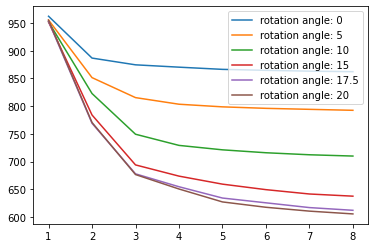

In [6]:
# Model selection - choose best angle

# first, find rotation angle that looks best. Below it is 20.
plot_angle_selection(loss_array,rotation_angle_list=rotation_angle_list)

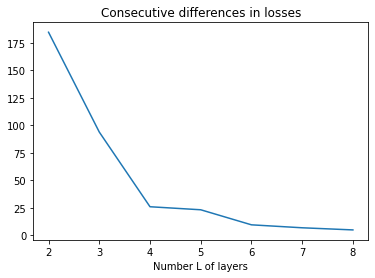

In [7]:
# Then, using that rotation angle, plot consecutive differences and choose approximate elbow
# Below, we select L=6

best_angle=20
plot_model_selection_nlayers_rotation(loss_array, best_angle,rotation_angle_list=rotation_angle_list)

**Step 3: Get layer labels from Belayer and plot**

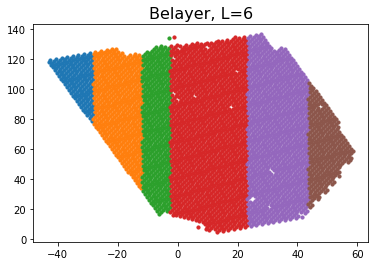

In [8]:
# Plot the labels from Belayer

best_L=6
belayer_labels, belayer_rotated_coords=visualized_rotated_belayer_output(label_dict, coords, best_L, 
                                                                         best_angle,
                                                   rotation_angle_list=rotation_angle_list)


**Step 4: spatially varying gene analysis**



In [9]:
# filter out low UMI genes
idx_kept=svg.select_commonly_expressed_genes(count, q=0.85, threshold=0, pooling=False)
print("number of kept genes = {}".format(len(idx_kept)))

# get slopes, offsets
depth=belayer_rotated_coords[:,0] # depth=rotated x-coordinate
slope_offsets=svg.segmented_poisson_regression(count[idx_kept,:], np.sum(count,axis=0), 
                                               belayer_labels, depth)



number of kept genes = 2031


In [10]:
slope_offsets

,intercept 0.0,slope 0.0,intercept 1.0,slope 1.0,intercept 2.0,slope 2.0,intercept 3.0,slope 3.0,intercept 4.0,slope 4.0,intercept 5.0,slope 5.0
0,-7.972960,0.059855,-8.605955,0.023284,-9.803035,-0.080834,-9.150162,0.013839,-8.401987,-0.021450,-5.434744,-0.073715
1,-9.194856,-0.000026,-8.597478,0.041043,-8.692879,0.089460,-9.227165,-0.008738,-9.976980,0.016271,-9.400918,0.007837
2,-9.843707,-0.040185,-9.146309,-0.034895,-8.233032,0.018917,-8.358478,-0.001629,-8.220892,-0.007128,-9.071779,0.011713
3,-8.675974,0.005045,-9.423613,-0.031569,-8.191705,0.104579,-8.485741,-0.006051,-8.697736,0.005089,-9.664315,0.013672
4,-9.329653,-0.021948,-9.230337,-0.021102,-8.682621,0.000419,-8.619582,0.008496,-8.581258,0.001976,-7.569696,-0.020709
...,...,...,...,...,...,...,...,...,...,...,...,...
2026,-5.945980,0.021158,-6.306195,-0.000376,-6.935760,-0.071229,-6.550335,-0.003889,-6.550688,-0.010187,-7.414230,0.000008
2027,-3.827784,0.006653,-3.870980,0.000183,-4.119395,-0.035121,-3.939453,-0.001111,-3.981953,-0.004751,-4.450614,0.001467
2028,-5.807821,0.002546,-5.655721,-0.005657,-5.998766,-0.056912,-5.768734,-0.003174,-5.751485,-0.011276,-7.145973,0.013467
2029,-6.860190,0.056313,-8.904045,-0.018375,-9.130535,-0.058510,-8.861714,0.000342,-9.157069,0.006504,-8.762288,-0.009870


In [11]:
# For example, NEFM and HPCAL1 are the two genes with largest absolute slopes in layer 4 
gene_labels[ idx_kept[ np.argsort( np.abs(slope_offsets['slope 3.0']) )[::-1][:2] ] ]

array(['ENSG00000115756', 'ENSG00000100285'], dtype=object)

/n/fs/ragr-research/projects/network-mutations/belayer/src/svg.py:145: RuntimeWarning: divide by zero encountered in log
  
/n/fs/ragr-research/projects/network-mutations/belayer/src/svg.py:145: RuntimeWarning: divide by zero encountered in log
  
/n/fs/ragr-research/projects/network-mutations/belayer/src/svg.py:145: RuntimeWarning: divide by zero encountered in log
  
/n/fs/ragr-research/projects/network-mutations/belayer/src/svg.py:145: RuntimeWarning: divide by zero encountered in log
  


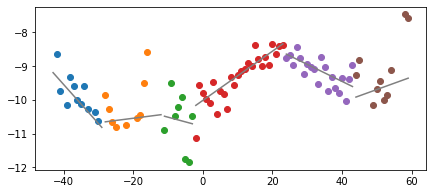

In [18]:
# we can also visualize the piecewise linear expression functions

# first, bin the data
binning_output=svg.bin_data(count, belayer_labels, depth)

# plot NEFH
# (note that bins with count 0 are not plotted which is why fits are slightly off)
g=np.where(gene_labels=='ENSG00000100285')[0][0]
svg.plot_gene_pwlinear(g, idx_kept, count, slope_offsets, depth, binning_output)

# Dataset 2: mouse skin wound (10x Visium)

**Step 1: load data**

Note that we also load _approximate layer boundaries_ in the form of a boundary file - a NumPy array [L1, L2] where L1 and L2 are NumPy arrays containing the coordinates of the left

In [19]:
input_10x_folder='/n/fs/ragr-data/users/congma/Codes/spatial_embedding/data/SkinWoundPNAS/Visium/V19N18-025_A1/outs/'
count, coords, barcodes, genes=read_input_10xdirectory(input_10x_folder)

G,N=count.shape

# fill in gaps in 10x hexagonal grid
fullpoints, in_tissue = fill_geometry(coords, is_hexagon=True)

# get boundary points
boundary_file='/n/fs/ragr-data/users/congma/Codes/belayer-development/reproducibility/skin_wound/list_boundaries.npy'
boundary_list = read_boundary_list(boundary_file, fullpoints)



**Step 2: run/load GLMPCA**

In [20]:
# OPTION 1: generate GLM-PCA and save to file
# glmpca_res = glmpca.glmpca(count, 2*3, fam="poi", penalty=10, verbose=True)
# F_glmpca = glmpca_res['factors']
# np.save('INSERT/PATH/', F_glmpca)

# OPTION 2: load pre-computed GLM-PCs
F_glmpca=np.load(input_10x_folder+'glmpca_6PC_10.npy')

**Step 3: run harmonic interpolation for each pair of consecutive boundaries**

In this case there are only two boundaries so we run harmonic interpolation once

In [21]:
# harmonic interpolation
spos = spatialcoord(x = fullpoints[:,0], y = fullpoints[:,1])
har = harmonic(fullpoints, spos.adjacency_mat, np.sqrt(spos.pairwise_squared_dist))
interpolation = har.interpolation_using_list( boundary_list )
interpolated_coords = interpolation[in_tissue]

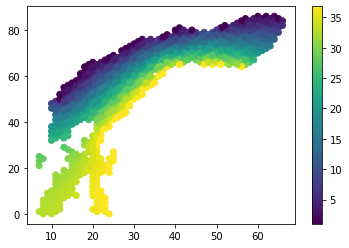

In [22]:
plt.scatter(coords[:,0],coords[:,1],c=interpolated_coords)
plt.colorbar()

**Step 4: Run DP, get clusters and plot**

In [23]:
# number of layers, in this case no model selection since we know skin has 3 layers
L=3

# run DP
error_mat, segment_map = dp_raw(F_glmpca.T, L, interpolated_coords)

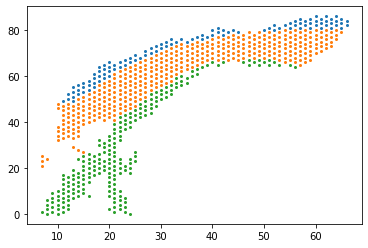

In [19]:
# same as above with my DP
segs = find_segments_from_dp(error_mat, segment_map, L,xcoords=interpolated_coords)
dp_labels = np.zeros(N, dtype=int)
c=0
for seg in segs:
    dp_labels[ seg ] = c
    c+=1

for t in np.unique(dp_labels):
    pts_t=np.where(dp_labels==t)
    plt.scatter(coords[pts_t,0],coords[pts_t,1],s=4)


In [ ]:

# output labels
df_dp_labels = pd.DataFrame({"depth":interpolation, "layer":dp_labels}, index=barcodes)
df_dp_labels.to_csv(args.outprefix + "_layers.txt", sep="\t")
# fitting expression function per gene
selected_genes = select_commonly_expressed_genes(count, interpolation, q=0.75)
totalumi = np.sum(count, axis=0)
df_gene_func = segmented_poisson_regression(count[selected_genes,:], totalumi, dp_labels, interpolation)
df_gene_func.index = genes[selected_genes]
# output per-gene regression parameter
df_gene_func.to_csv(args.outprefix + "_function_coefficients.txt", sep="\t")

# Dataset 3: mouse somatosensory cortex (Slide-SeqV2)